## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import warnings
import urllib.request
import json
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from random import randint
from matplotlib import rcParams
from pylab import *
from scipy.interpolate import make_interp_spline, BSpline

## Load Data Function

In [2]:
def load_data(start_year, end_year, parameter):
    year = start_year - 1
    size = (end_year - start_year + 1) * 12
    month = 1
    x = [[]for i in range (size)]
    for i in range(0, size):
        year = year + 1 if ((i + 1) % 12) == 1 else year
        ms = '0' + str(month) if month<10 else str(month)
        filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
        path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
        x[i] = pd.read_csv(path + filename, header=None)
        month = month + 1 if month < 12 else 1
    return x

## Get Latitude and Longitude Functions

In [3]:
def findItem(theList, item):
    pos_list = [[ind, theList[ind].index(item)] for ind in range(len(theList)) if item in theList[ind]]
    return [pos_list[0][0], pos_list[0][1]]

def find_step(start, end, abs_step):
    act_step = abs(abs_step) if start < end else -abs(abs_step)
    return act_step

def create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step):
    lat = np.arange(start_lat, end_lat + lat_step, lat_step).tolist()
    lon = np.arange(start_lon, end_lon + lon_step, lon_step).tolist()
    grid = [[[]for i in range(len(lon))] for j in range(len(lat))]
    y = 0
    for i in range(0, len(lat)):
        for j in range(0, len(lon)):
            grid[i][j] = y
            y += 1
    return grid, lat, lon

def get_ll(index, grid, lat_list, lon_list):
    return lat_list[findItem(grid, index)[0]], lon_list[findItem(grid, index)[1]]

def get_index(latitude, longitude, grid, lat_list, lon_list):
    longitude = longitude + 180
    return grid[lat_list.index(latitude)][lon_list.index(longitude)]

# print(get_ll(619683))
# print(get_index(-30.75,14))

## Get Elevation Function

In [4]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return [elevation, elevation / 1000]

## ARIMA Function

In [5]:
def arima_model(data, numpr):
    X = data
    actual_size = len(data)
    train_size = int(0.75*len(data))
    train = X[0:train_size]
    test = X[train_size - 1:]
    
    best_aic = 99999
    p=(3,4,6)
    # p=range(1,6)
    d=range(0,1)
    q=range(1,5)
    pdq = list(itertools.product(p, d, q))
    
    warnings.filterwarnings('ignore')
    for param in pdq:
        try:
            model_arima = ARIMA(train, order = param)
            model_arima_fit = model_arima.fit()
            aic = model_arima_fit.aic
            print(param, aic)
            if aic < best_aic:
                best_aic = aic
                best_pdq = param
                best_fit = model_arima_fit
        except:
            continue
    
    model_arima = ARIMA(train, order=best_pdq)
    # model_arima_fit = model_arima.fit()
    aic = best_fit.aic
    predictions = best_fit.forecast(steps=(actual_size - train_size + 1 + numpr))[0]
    mse = mean_squared_error(test, predictions[0:len(test)])
    return predictions, train, test, aic, mse, best_pdq

## Data Loading

In [6]:
start_time = time.time()
tcwv_data = load_data(1979, 2019, 'tcwv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 188.68231511116028 seconds ---


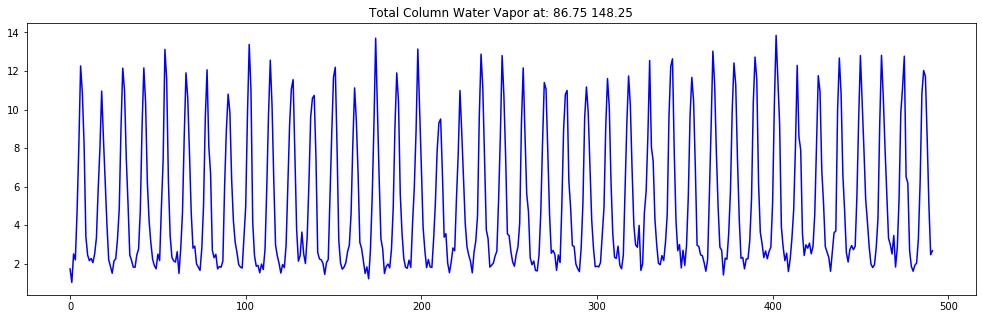

In [7]:
tcwv_values = [0] * (len(tcwv_data))
pos = randint(0, 1038239)
for i in range(len(tcwv_data)):
    tcwv_values[i] = tcwv_data[i][0].values[pos]

start_lat = 90
end_lat = -90
start_lon = 0
end_lon = 359.75
step = 0.25
lat_step = find_step(start_lat, end_lat, step)
lon_step = find_step(start_lon, end_lon, step)
    
lists = create_list(start_lat, end_lat, start_lon, end_lon, lat_step, lon_step)
grid_list = lists[0]
lat_list = lists[1]
lon_list = lists[2]
rcParams['figure.figsize'] = 17, 5

plt.plot(tcwv_values, 'b')
latstr = str(get_ll(pos, grid_list, lat_list, lon_list)[0])
lonstr = str(get_ll(pos, grid_list, lat_list, lon_list)[1] - 180)
# print('At position:', latstr, lonstr)
title = 'Total Column Water Vapor at: ' + latstr + ' ' + lonstr
plt.title(title)
# plt.savefig('figure.png')
plt.show()

(3, 0, 2) 1250.9663401789749
(4, 0, 4) 897.0313461864098


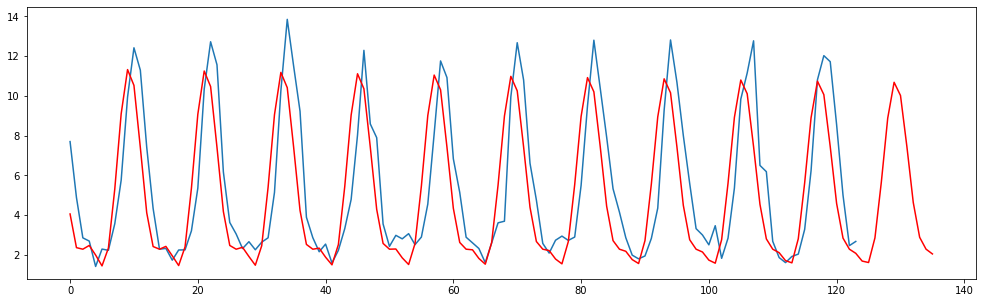

P, D, Q (4, 0, 4)
AIC: 897.0313461864098
MSE: 5.13503229021169


In [8]:
arima_func = arima_model(tcwv_values, 12)
predictions = arima_func[0]
train = arima_func[1]
test = arima_func[2]
aic = arima_func[3]
mse = arima_func[4]
best_pdq = arima_func[5]
str_i = 'AIC: ' + str(aic) + '\nMSE: ' + str(mse)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show()

print('P, D, Q', best_pdq)
print(str_i)

In [9]:
def find_lat(lat_list, any_lat, step):
    lat = min(lat_list, key=lambda x: abs(x - any_lat))
    if any_lat - lat < 0:
        lat_t = lat
        lat_b = lat - step
    else:
        lat_t = lat + step
        lat_b = lat
    return lat_b, lat_t

def find_lon(lon_list, any_lon, step):
    any_lon = any_lon + 180
    lon = min(lon_list, key=lambda x: abs(x - any_lon))
    if any_lon - lon < 0:
        lon_r = lon
        lon_l = lon - step
    else:
        lon_r = lon + step
        lon_l = lon
    return lon_l, lon_r, lon_l - 180, lon_r -180
'''
cv_lat = find_lat(lat_list, 17.36, step)
cv_lon = find_lon(lon_list, -61.29, step)
print('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])
print('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])
'''

"\ncv_lat = find_lat(lat_list, 17.36, step)\ncv_lon = find_lon(lon_list, -61.29, step)\nprint('Bottom Latitude', cv_lat[0], 'Top Latitude', cv_lat[1])\nprint('Left Longitude', cv_lon[2], 'Right Longitude', cv_lon[3])\n"

In [10]:
def interp(lat, lon, month, year, parameter, grid, lat_list, lon_list, step):
    ms = '0' + str(month) if month<10 else str(month)
    filename = 'v' + parameter + str(year) + ms + '01' + '.txt'
    path = path = '~/Documents/Tesis/Data/' + parameter + '/' + str(year) + '/'
    data = pd.read_csv(path + filename, header=None)
    if (lat % 0.25) == 0 and (lon % 0.25) == 0:
        pos = get_index(lat, lon, grid, lat_list, lon_list)
        return data[0].values[pos]
    else:
        cv_lat = find_lat(lat_list, lat, step)
        cv_lon = find_lon(lon_list, lon, step)
        lat_0 = cv_lat[0]
        lat_1 = cv_lat[1]
        lon_a = cv_lon[2]
        lon_b = cv_lon[3]
        tl = get_index(lat_1, lon_a, grid, lat_list, lon_list)
        tr = tl + 1# get_index(lat_1, lon_b, grid, lat_list, lon_list)
        bl = tl + 1440# get_index(lat_0, lon_a, grid, lat_list, lon_list)
        br = bl + 1# get_index(lat_0, lon_b, grid, lat_list, lon_list)
        t = (lat - lat_0) / (lat_1 - lat_0)
        s = (lon - lon_a) / (lon_b - lon_a)
        X_tl = data[0].values[tl]
        X_tr = data[0].values[tr]
        X_bl = data[0].values[bl]
        X_br = data[0].values[br]
        value = (1 - s) * (1 - t) * X_bl + (1 - s) * t * X_tl + s * (1 - t) * X_br + t * s * X_tr
        # print([lat_1, lon_a + 180], [lat_1, lon_b + 180], '\n', [lat_0, lon_a + 180], [lat_0, lon_b + 180])
        # print('', round(X_tl, 4), round(X_tr, 4), '\n', round(X_bl, 4), round(X_br, 4))
        # print([lat_1, lon_a], [lat_1, lon_b], '\n', [lat_0, lon_a], [lat_0, lon_b])
        # print(tl, tr, '\n', bl, br)
        return value       

# interp(-17.35, -98.69, 1, 1985, 'tcwv', grid_list, lat_list, lon_list, step)
interp(-16.51, -68.17, 9, 1985, 'tcwv', grid_list, lat_list, lon_list, step)

22.6604655705136

In [11]:
def timeseries(sy, ey, lat, lon):
    c = 0
    aux_val = [0] * (ey - sy + 1) * 12
    aux_time = [0] * (ey - sy + 1) * 12
    for i in range(sy, ey + 1):
        for j in range(1, 13):
            aux_val[c] = interp(lat, lon, j, i, 'tcwv', grid_list, lat_list, lon_list, step)
            aux_time[c] = str(j) + '-' + str(i)
            c += 1
    return aux_val, aux_time

In [12]:
result = timeseries(1979,2019, -16.51, -68.17)
tcwv_p = result[0]
tcwv_t = result[1]

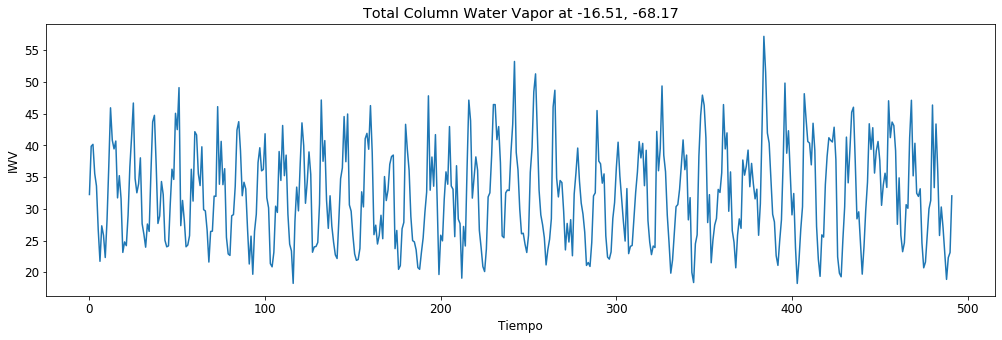

In [13]:
tcwv_p = np.array(tcwv_p)
rcParams['figure.figsize'] = 17, 5
rcParams['font.size'] = 12
plt.plot(tcwv_p)
plt.title('Total Column Water Vapor at -16.51, -68.17')
plt.ylabel('IWV')
plt.xlabel('Tiempo')
plt.show()

In [14]:
def plothist(array, title, nb=10):
    hist, bin_edges = np.histogram(array, bins = nb)
    bin_edges = np.round(bin_edges,0)
    plt.bar(bin_edges[:-1], hist, width = 0.9, color='#0504aa',alpha=0.7)
    plt.xlim(min(bin_edges)-2, max(bin_edges))
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('IWV',fontsize=15)
    plt.ylabel('Porcentaje',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize=15)
    plt.show()

## Total Histogram

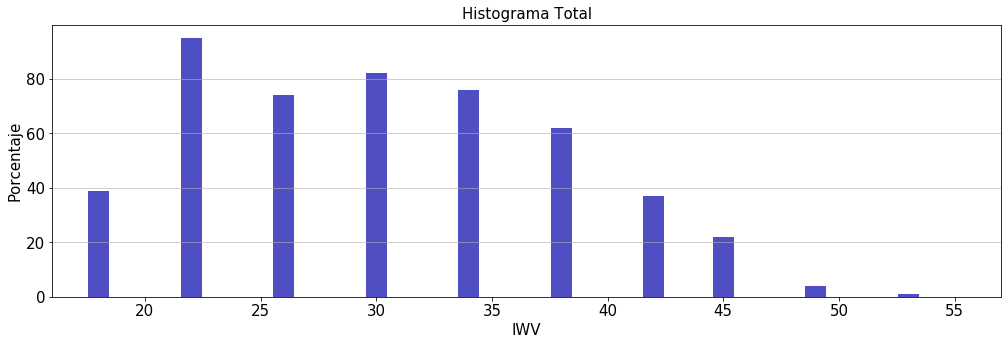

In [15]:
plothist(tcwv_p, 'Histograma Total', 10)

In [16]:
# Seasons
# Summer January February March
# Autumn April May June
# Winter July August September
# Spring October November December
def ex_season(array, start, end):
    pos = 0
    c = 0
    y = int((len(array)/12))
    aux = [0] * (end - start + 1) * y
    for i in range(0,y):
        for j in range(start,end + 1):
            aux[c] = array[pos + j]
            # print(str(pos + j) + '|' + str(c))
            c += 1
        pos += 12
    return aux

In [17]:
summertcwv = ex_season(tcwv_p, 0, 2)
autumntcwv = ex_season(tcwv_p, 3, 5)
wintertcwv = ex_season(tcwv_p, 6, 8)
springtcwv = ex_season(tcwv_p, 9, 11)

## Summer

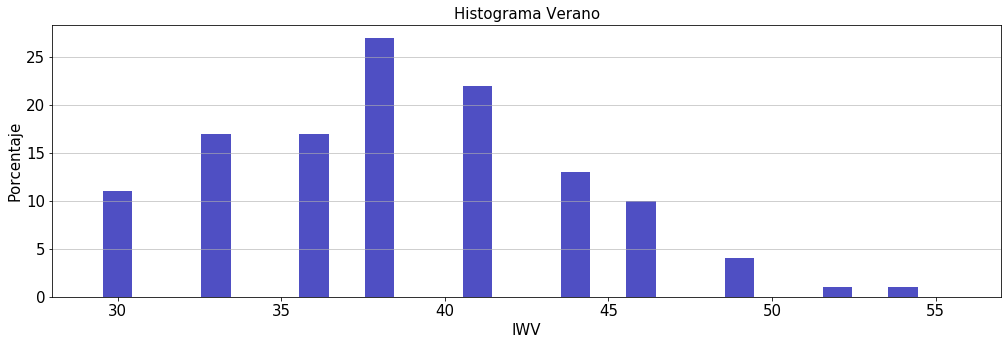

In [18]:
plothist(summertcwv, 'Histograma Verano')

## Autumn

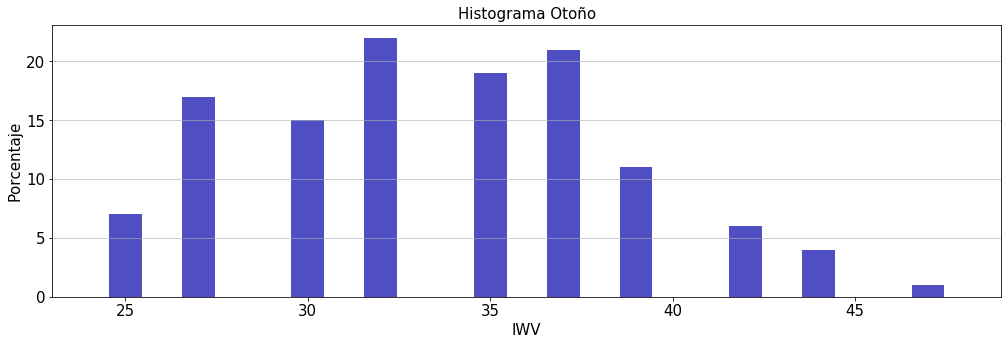

In [19]:
plothist(autumntcwv, 'Histograma Otoño')

# Winter

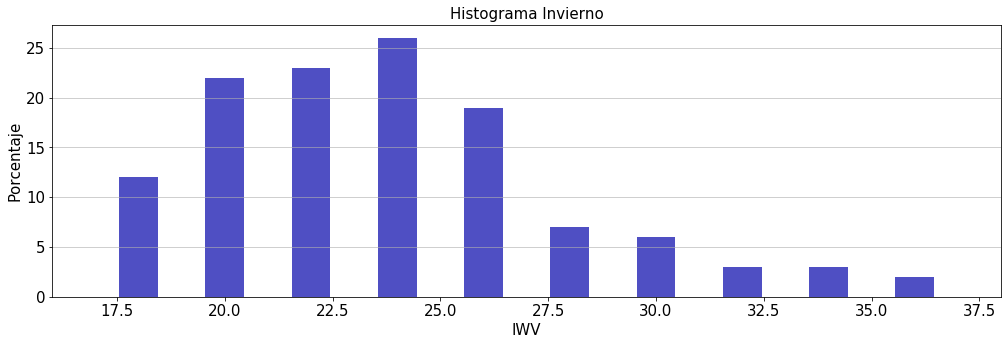

In [20]:
plothist(wintertcwv, 'Histograma Invierno')

## Spring

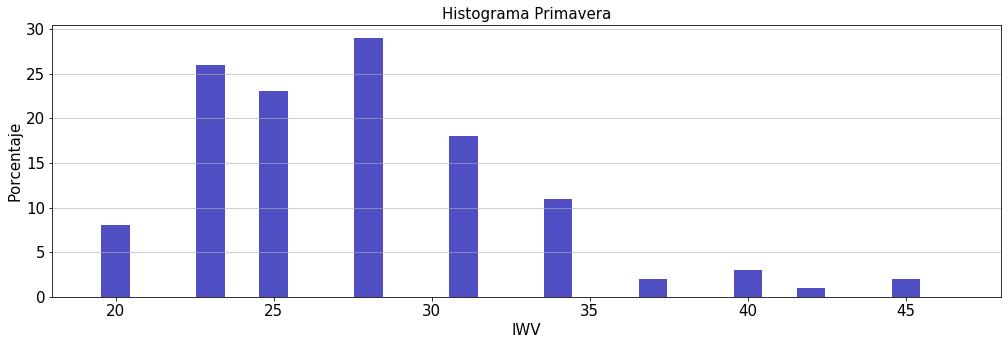

In [21]:
plothist(springtcwv, 'Histograma Primavera')

## CDF

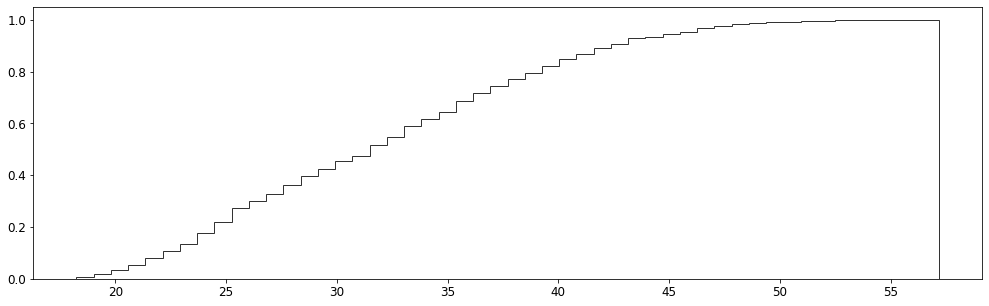

In [63]:
n = plt.hist(tcwv_p, bins=50, normed=True, cumulative=True, log=False, label='CDF', histtype='step', alpha=0.8, color='k')

In [64]:
X = np.delete(n[1], -1)
cdf_Y = n[0]
ccdf_Y = 1-n[0]
print(len(X),len(cdf_Y), len(ccdf_Y))

50 50 50


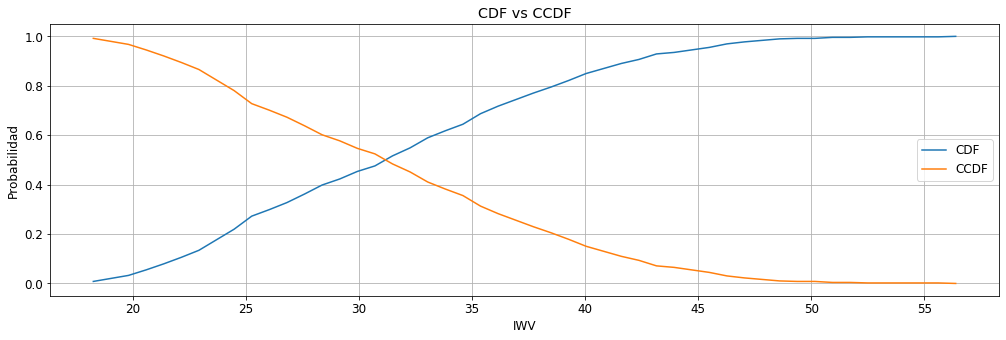

In [65]:
plt.grid(True, which="both")
plt.plot(X, cdf_Y, label='CDF')
plt.plot(X, ccdf_Y, label='CCDF')
plt.legend(loc='upper mid')
plt.xlabel('IWV')
plt.ylabel('Probabilidad')
plt.title('CDF vs CCDF')
plt.show()

## Smoothing the plot

In [58]:
def smplot(X, Y, p = 300):
    X = np.array(X)
    Y = np.array(Y)
    newx = np.linspace(X.min(), X.max(), 300)
    spl = make_interp_spline(X, Y, k=3)
    smoothy = spl(newx)
    return newx, smoothy

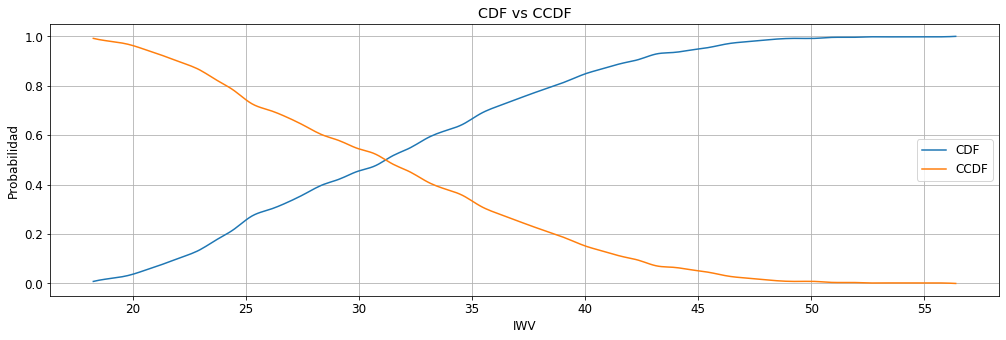

In [66]:
sm = smplot(X, cdf_Y)
sm_X = sm[0]
sm_cdf_Y = sm[1]
sm_ccdf_Y = smplot(X, ccdf_Y)[1]
plt.grid(True, which="both")
plt.plot(sm_X, sm_cdf_Y, label='CDF')
plt.plot(sm_X, sm_ccdf_Y, label='CCDF')
plt.legend(loc='upper mid')
plt.xlabel('IWV')
plt.ylabel('Probabilidad')
plt.title('CDF vs CCDF')
plt.show()